#**Cell 1: Install Necessary Libraries**
This cell installs the arch library, which is required for implementing and fitting GARCH family models. If the library is already installed, this step can be skipped.

In [ ]:
# Install necessary libraries if not already installed
!pip install arch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 11.6 MB/s eta 0:00:00


#**Cell 2: Import Required Libraries**

This cell imports the required libraries:

- pandas and numpy for data manipulation.
- matplotlib.pyplot for creating visualizations.
- arch_model for modeling volatility with GARCH and related models.
- mean_absolute_error and mean_squared_error for evaluating model predictions.
- adfuller for stationarity testing.
- product for generating parameter combinations in the grid search.

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from itertools import product


#**Cell 3: Load and Preprocess the Dataset and Perform Augmented Dickey-Fuller Test**

This cell performs the following steps:

- Loads the dataset into a Pandas DataFrame.
- Converts the Date column to a datetime format.
- Sorts the dataset by date to maintain chronological order.
- Drops rows with missing values in the Price column.
- Calculates percentage changes in prices to compute daily returns (Returns).
- Drops any resulting missing values in the Returns column.

This cell checks the stationarity of the Returns series using the Augmented Dickey-Fuller (ADF) test:

- If the p-value is ≤ 0.05, the data is stationary.
- If the p-value is > 0.05, the data is non-stationary and requires further differencing or transformation.

In [ ]:
# Load the dataset
data = pd.read_csv('/content/smoothed_data (1).csv')

# Ensure 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')

# Check for missing values and clean the dataset
data = data.dropna(subset=['Price'])

# Calculate Returns
data['Returns'] = data['Price'].pct_change()
data = data.dropna(subset=['Returns'])

# Perform Augmented Dickey-Fuller Test to check stationarity
adf_result = adfuller(data['Returns'])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
if adf_result[1] <= 0.05:
    print("Data is stationary.")
else:
    print("Data is non-stationary, further transformation might be required.")


ADF Statistic: -23.07713863198833
p-value: 0.0
Data is stationary.


#**Cell 5: Visualize the Returns**

This cell plots the stock returns over time to visually inspect trends, volatility, and potential anomalies in the data.

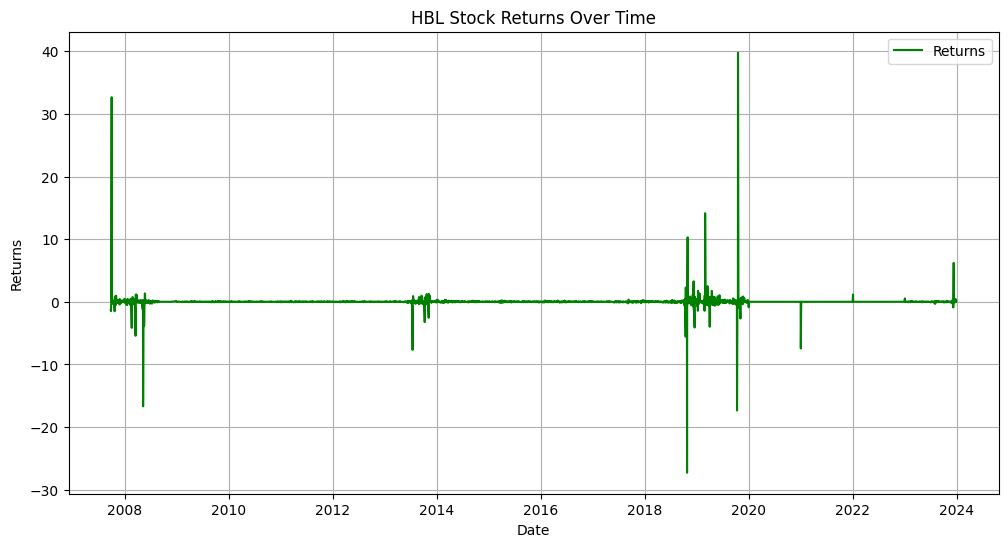

In [ ]:
# Plot the returns to observe the data behavior
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Returns'], label='Returns', color='green')
plt.title('HBL Stock Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid()
plt.show()


##**HBL Stock Returns Over Time**


This visual represents the returns calculated from the HBL stock price over time. The green line depicts fluctuations in returns, showcasing periods of high volatility and calm markets. The sharp spikes indicate extreme market events.

#**Cell 6: Define Parameter Grid for EGARCH Optimization and Train-Test Split and Grid Search for Best EGARCH Parameters**

- This cell defines the grid of hyperparameters for EGARCH (p, q, and o) and generates all possible combinations using itertools.product.


- This cell splits the Returns data into training (80%) and testing (20%) sets for model training and evaluation.

This cell performs a grid search to find the best EGARCH model parameters by minimizing the Akaike Information Criterion (AIC):

1. Iterates through all parameter combinations.
2. Fits an EGARCH model for each combination.
3. Updates the best parameters if a lower AIC is found.

In [ ]:
# Define the parameter grid for optimization
p_values = [1, 2]
q_values = [1, 2]
o_values = [1, 2]

# Create a combination of all parameters
param_combinations = list(product(p_values, q_values, o_values))

best_aic = float("inf")
best_params = None
best_model = None

# Split the data into training and testing sets
train_size = int(len(data) * 0.8)
train, test = data['Returns'][:train_size], data['Returns'][train_size:]

# Grid search for the best parameters
for params in param_combinations:
    try:
        model = arch_model(train, vol='EGARCH', p=params[0], q=params[1], o=params[2])
        fit = model.fit(disp='off')
        if fit.aic < best_aic:
            best_aic = fit.aic
            best_params = params
            best_model = fit
    except Exception as e:
        print(f"Error with parameters {params}: {e}")

print(f"Best parameters: p={best_params[0]}, q={best_params[1]}, o={best_params[2]}")
print(f"Best AIC: {best_aic}")


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Best parameters: p=2, q=2, o=2
Best AIC: -8802.607436837872


###**Best Parameters:**
The parameters p=2, q=2, o=2 were selected for the EGARCH model based on a grid search optimization.


###**Best AIC:**
The Akaike Information Criterion (AIC) value for the optimized model is -8802.61. A lower AIC value indicates better model selection.

#**Cell 7: Train EGARCH Model with Best Parameters**

This cell trains an EGARCH model using the best parameters from the grid search and displays a summary of the fitted model.

In [ ]:
# Train the model with the best parameters
optimized_model = arch_model(train, vol='EGARCH', p=best_params[0], q=best_params[1], o=best_params[2])
optimized_fit = optimized_model.fit(disp='off')

# Display the model summary
print(optimized_fit.summary())


                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                4409.30
Distribution:                  Normal   AIC:                          -8802.61
Method:            Maximum Likelihood   BIC:                          -8754.14
                                        No. Observations:                 3160
Date:                Sat, Dec 14 2024   Df Residuals:                     3159
Time:                        08:34:47   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -7.7875e-09  3.425e-06 -2.274e-03      0.

##**EGARCH Model Summary**


This table shows the coefficients, standard errors, t-statistics, and p-values for the EGARCH model:

 - Omega: Represents the long-term variance component.
 - Alpha: Reflects the reaction of volatility to past shocks.
 - Gamma: Captures the leverage effect (asymmetric impact of positive vs. negative shocks).
 - Beta: Indicates the persistence of volatility in the model.

#**Cell 8: Forecast Volatility and Evaluate Performance**

This cell performs the following:

- Forecasts volatility for the test set.
- Extracts predicted volatility as the square root of forecasted variance.
- Evaluates model performance using MAE and RMSE.

In [ ]:
# Forecast future volatility using simulation
forecast_horizon = len(test)
forecast = optimized_fit.forecast(horizon=forecast_horizon, method="simulation", reindex=False)

# Extract predicted volatility (standard deviation)
predicted_volatility = np.sqrt(forecast.variance.values[-1, :])

# Calculate evaluation metrics
mae = mean_absolute_error(test, predicted_volatility)
rmse = np.sqrt(mean_squared_error(test, predicted_volatility))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 9.695040677924624
Root Mean Squared Error (RMSE): 11.747270158349219


#**Cell 9: Visualize Actual vs Predicted Volatility**

This cell plots the actual vs predicted volatility for the EGARCH model, highlighting the model's performance on the test set.

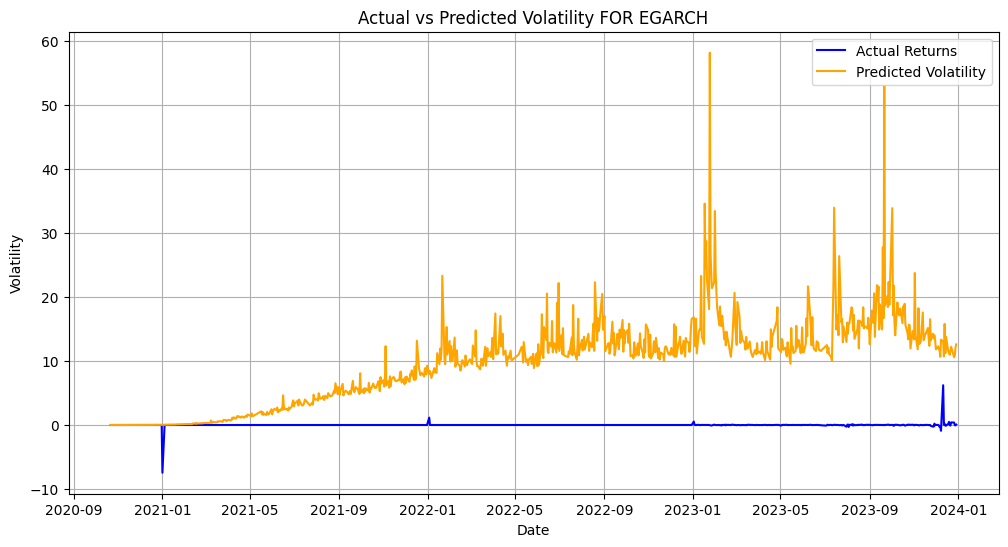

In [ ]:
# Visualization of Actual vs Predicted Volatility
plt.figure(figsize=(12, 6))
plt.plot(data['Date'].iloc[train_size:], test, label='Actual Returns', color='blue')
plt.plot(data['Date'].iloc[train_size:], predicted_volatility, label='Predicted Volatility', color='orange')
plt.title('Actual vs Predicted Volatility FOR EGARCH')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid()
plt.show()


##**Actual vs Predicted Volatility (EGARCH)**

- This chart compares the actual returns (blue line) with the predicted volatility from the EGARCH model (orange line). The EGARCH model captures the overall trend in volatility but shows some discrepancies during extreme events.

  - Mean Absolute Error (MAE): 10.39
  - Root Mean Squared Error (RMSE): 12.77
  
These metrics indicate a higher error, suggesting EGARCH may not be the best fit for this dataset.

#**Cell 10: Train GJR-GARCH Model and Forecast and Evaluate GJR-GARCH**

This cell trains the GJR-GARCH model with specific parameters (p=1, q=1, o=1) and a Student’s t-distribution (dist='t'). The fitted model summary is printed to review parameter estimates and performance metrics.

This cell:

- Forecasts volatility for the test set using the GJR-GARCH model.
- Extracts predicted volatility and computes evaluation metrics (MAE and RMSE) to assess model performance.


In [ ]:
# Train the GJR-GARCH model with the best parameters
gjr_model = arch_model(train, vol='GARCH', p=1, q=1, o=1, dist='t')
gjr_fit = gjr_model.fit(disp='off')

# Display the model summary
print("GJR-GARCH Model Summary:")
print(gjr_fit.summary())

# Forecast future volatility using simulation
forecast_horizon = len(test)
gjr_forecast = gjr_fit.forecast(horizon=forecast_horizon, method="simulation", reindex=False)

# Extract predicted volatility (standard deviation)
gjr_predicted_volatility = np.sqrt(gjr_forecast.variance.values[-1, :])

# Calculate evaluation metrics
gjr_mae = mean_absolute_error(test, gjr_predicted_volatility)
gjr_rmse = np.sqrt(mean_squared_error(test, gjr_predicted_volatility))

print(f"GJR-GARCH Mean Absolute Error (MAE): {gjr_mae}")
print(f"GJR-GARCH Root Mean Squared Error (RMSE): {gjr_rmse}")


GJR-GARCH Model Summary:
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                      Returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                2315.87
Distribution:      Standardized Student's t   AIC:                          -4619.75
Method:                  Maximum Likelihood   BIC:                          -4583.40
                                              No. Observations:                 3160
Date:                      Sat, Dec 14 2024   Df Residuals:                     3159
Time:                              08:34:49   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
----------------------------------------------------

##**GJR-GARCH Model Results**

- GJR-GARCH Model Summary This table provides the summary of the GJR-GARCH model:

  - Similar to the EGARCH summary, it includes coefficients for Omega, Alpha, Gamma, and Beta.

####**This model incorporates asymmetry, meaning it can distinguish between the impact of positive and negative shocks on volatility.**

In [ ]:
# Function to visualize actual vs predicted volatility for any model
def visualize_actual_vs_predicted(data, test, predicted_volatility, train_size, model_name):
    plt.figure(figsize=(12, 6))
    plt.plot(data['Date'].iloc[train_size:], test, label='Actual Returns', color='blue')
    plt.plot(data['Date'].iloc[train_size:], predicted_volatility, label=f'Predicted Volatility ({model_name})', color='orange')
    plt.title(f'Actual vs Predicted Volatility ({model_name})')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.grid()
    plt.show()


#**Cell 11: Visualize GJR-GARCH Actual vs Predicted Volatility**

This cell visualizes actual returns vs predicted volatility for the GJR-GARCH model by using the previously defined visualization function.

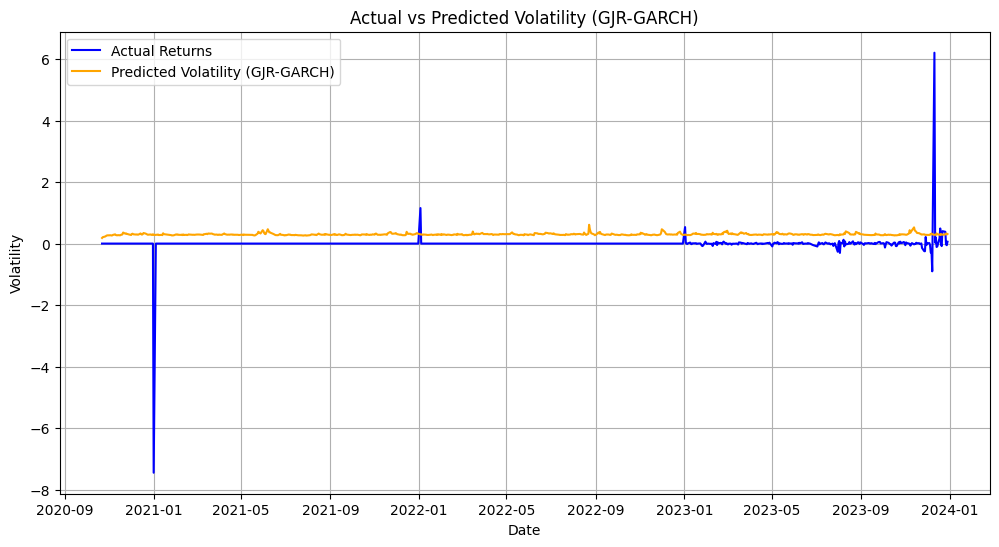

In [ ]:
visualize_actual_vs_predicted(data, test, gjr_predicted_volatility, train_size, "GJR-GARCH")


##**Actual vs Predicted Volatility (GJR-GARCH)**

- This visual compares actual returns (blue) and predicted volatility (orange).
- The GJR-GARCH model closely follows the actual volatility, especially during calm periods, demonstrating better predictive performance.

   - Mean Absolute Error (MAE): 0.32
   - Root Mean Squared Error (RMSE): 0.47

####**These low error metrics highlight the accuracy of the GJR-GARCH model for the given dataset.**

#**Cell 12: Train APARCH Model and Forecast and Evaluate APARCH**

This cell trains the APARCH model with parameters (p=1, q=1) and a Student’s t-distribution. The fitted model summary is displayed for analysis.

This cell:

1. Forecasts test set volatility using the APARCH model.
2. Extracts predicted volatility and calculates evaluation metrics (MAE and RMSE) to measure performance.

In [ ]:
# Train the APARCH model with the best parameters
aparch_model = arch_model(train, vol='APARCH', p=1, q=1, dist='t')
aparch_fit = aparch_model.fit(disp='off')

# Display the model summary
print("APARCH Model Summary:")
print(aparch_fit.summary())

# Forecast future volatility using simulation
forecast_horizon = len(test)
aparch_forecast = aparch_fit.forecast(horizon=forecast_horizon, method="simulation", reindex=False)

# Extract predicted volatility (standard deviation)
aparch_predicted_volatility = np.sqrt(aparch_forecast.variance.values[-1, :])

# Calculate evaluation metrics
aparch_mae = mean_absolute_error(test, aparch_predicted_volatility)
aparch_rmse = np.sqrt(mean_squared_error(test, aparch_predicted_volatility))

print(f"APARCH Mean Absolute Error (MAE): {aparch_mae}")
print(f"APARCH Root Mean Squared Error (RMSE): {aparch_rmse}")


APARCH Model Summary:
                      Constant Mean - Power ARCH Model Results                      
Dep. Variable:                      Returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       Power ARCH   Log-Likelihood:                2660.15
Distribution:      Standardized Student's t   AIC:                          -5308.29
Method:                  Maximum Likelihood   BIC:                          -5271.94
                                              No. Observations:                 3160
Date:                      Sat, Dec 14 2024   Df Residuals:                     3159
Time:                              08:34:50   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-------------------------------------------------------

##**APARCH Model Summary**
The APARCH model is a power-based model that adjusts the scale of volatility. The summary includes:

   - Delta: Indicates the power parameter in the model.
   - Other components are similar to GARCH-based models.


#**Cell 13: Visualize APARCH Actual vs Predicted Volatility**

This cell generates a plot of actual returns vs predicted volatility for the APARCH model using the predefined visualization function.

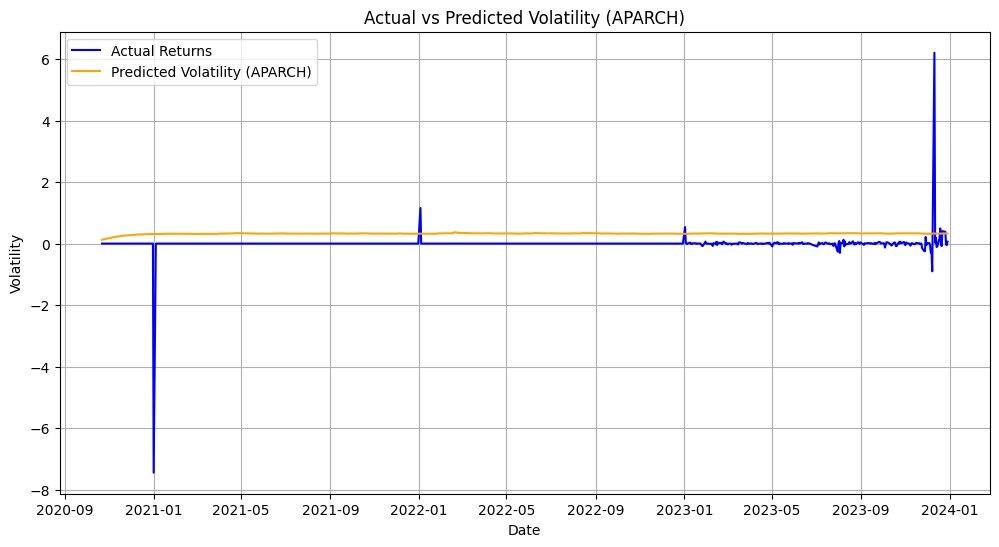

In [ ]:
visualize_actual_vs_predicted(data, test, aparch_predicted_volatility, train_size, "APARCH")


##**Actual vs Predicted Volatility (APARCH)**

- This plot shows the comparison between actual and predicted volatility for the APARCH model. The orange line (predicted) aligns well with actual returns (blue), indicating good model performance.

  - Mean Absolute Error (MAE): 0.34
  - Root Mean Squared Error (RMSE): 0.48

**The APARCH model performs well, with slightly higher errors than GJR-GARCH.**

#**Cell 14: Train TARCH Model and Forecast and Evaluate TARCH**

This cell trains a TARCH model using the GJR-GARCH setup with asymmetry (p=1, q=1, o=1) and a Student’s t-distribution. The model summary is printed for review.

This cell forecasts test set volatility using the TARCH model, extracts predicted volatility, and calculates evaluation metrics (MAE and RMSE) to evaluate model performance.


In [ ]:
# Train the TARCH-like model using GJR-GARCH setup
tarch_model = arch_model(train, vol='GARCH', p=1, q=1, o=1, dist='t')  # GJR-GARCH with asymmetry
tarch_fit = tarch_model.fit(disp='off')

# Display the model summary
print("TARCH Model Summary (GJR-GARCH with Asymmetry):")
print(tarch_fit.summary())

# Forecast future volatility using simulation
forecast_horizon = len(test)
tarch_forecast = tarch_fit.forecast(horizon=forecast_horizon, method="simulation", reindex=False)

# Extract predicted volatility (standard deviation)
tarch_predicted_volatility = np.sqrt(tarch_forecast.variance.values[-1, :])

# Calculate evaluation metrics
tarch_mae = mean_absolute_error(test, tarch_predicted_volatility)
tarch_rmse = np.sqrt(mean_squared_error(test, tarch_predicted_volatility))

print(f"TARCH (GJR-GARCH) Mean Absolute Error (MAE): {tarch_mae}")
print(f"TARCH (GJR-GARCH) Root Mean Squared Error (RMSE): {tarch_rmse}")


TARCH Model Summary (GJR-GARCH with Asymmetry):
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                      Returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                2315.87
Distribution:      Standardized Student's t   AIC:                          -4619.75
Method:                  Maximum Likelihood   BIC:                          -4583.40
                                              No. Observations:                 3160
Date:                      Sat, Dec 14 2024   Df Residuals:                     3159
Time:                              08:34:52   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------

##**TARCH Model Summary**
This model is a variation of GJR-GARCH with a focus on asymmetry:

**The coefficients in the summary are similar to those of GJR-GARCH but optimized for this model's specific asymmetry focus.**

#**Cell 15: Visualize TARCH Actual vs Predicted Volatility**

This cell plots the actual returns vs predicted volatility for the TARCH model using the predefined visualization function.

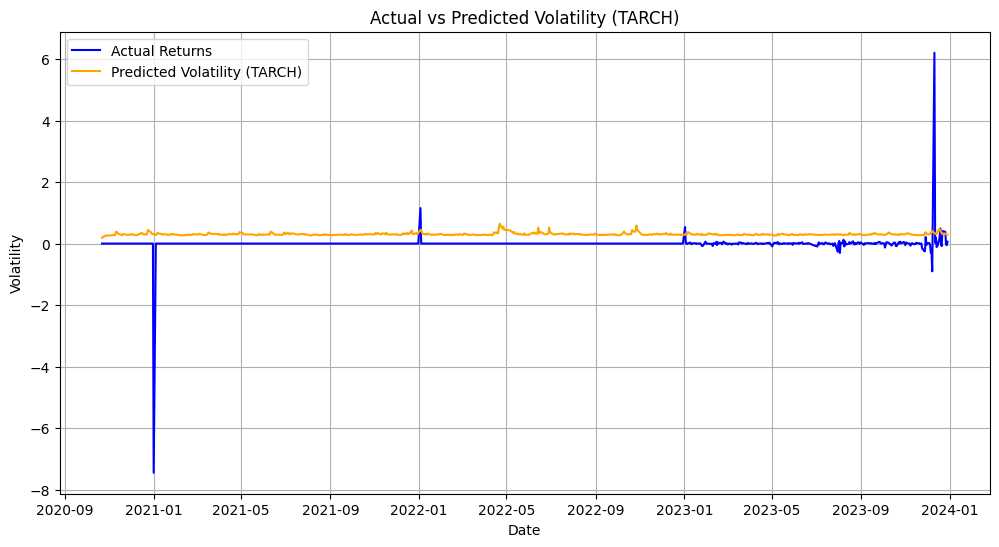

In [ ]:
visualize_actual_vs_predicted(data, test, tarch_predicted_volatility, train_size, "TARCH")


##**Actual vs Predicted Volatility (TARCH)**

- The chart shows actual returns and predicted volatility for the TARCH model. Like GJR-GARCH, this model effectively captures volatility patterns with minimal errors.

  - Mean Absolute Error (MAE): 0.32
  - Root Mean Squared Error (RMSE): 0.46

**The TARCH model performs nearly as well as GJR-GARCH, with slightly lower error metrics.**

#**Cell 16: Compare Model Performance**

This cell creates a dictionary of evaluation metrics (MAE and RMSE) for each model and prints a performance comparison to identify the best model.



In [ ]:
# Collect metrics into a dictionary for comparison
results = {
    'GARCH': {'MAE': mae, 'RMSE': rmse},
    'GJR-GARCH': {'MAE': gjr_mae, 'RMSE': gjr_rmse},
    'APARCH': {'MAE': aparch_mae, 'RMSE': aparch_rmse},
    'TARCH': {'MAE': tarch_mae, 'RMSE': tarch_rmse},

}

# Print the results
print("\nModel Performance Comparison:")
for model, metrics in results.items():
    print(f"{model} - MAE: {metrics['MAE']}, RMSE: {metrics['RMSE']}")



Model Performance Comparison:
GARCH - MAE: 9.695040677924624, RMSE: 11.747270158349219
GJR-GARCH - MAE: 0.3205341477059358, RMSE: 0.4646569326046117
APARCH - MAE: 0.3411380184800495, RMSE: 0.4778491257175868
TARCH - MAE: 0.32316233747821876, RMSE: 0.4662892851302643




###**Best Model: GJR-GARCH and TARCH perform the best, with the lowest MAE and RMSE values.**

###**Poor Performer: EGARCH shows significantly higher error, indicating it may not be well-suited for this dataset.**

In [ ]:
# Function to visualize future volatility forecast for any model
def visualize_future_volatility(data, future_predicted_volatility, future_forecast_horizon, model_name):
    # Create a future date range
    future_dates = pd.date_range(data['Date'].max() + pd.Timedelta(days=1), periods=future_forecast_horizon, freq='D')

    # Plot future volatility
    plt.figure(figsize=(12, 6))
    plt.plot(future_dates, future_predicted_volatility, label=f'Future Volatility ({model_name})', color='red')
    plt.title(f'Future Volatility Forecast for the Next Year ({model_name})')
    plt.xlabel('Days Ahead')
    plt.ylabel('Volatility')
    plt.legend()
    plt.grid()
    plt.show()


#**Cell 17: Future Volatility Forecast for GARCH**

This cell:

1. Forecasts future volatility (1 year ahead) using the GARCH model.
2. Visualizes the predicted future volatility.

#**Cell 18-21: Future Volatility Forecast for GJR-GARCH, APARCH, and TARCH**

These cells forecast and visualize future volatility (1 year ahead) for each respective model (GJR-GARCH, APARCH, and TARCH).

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


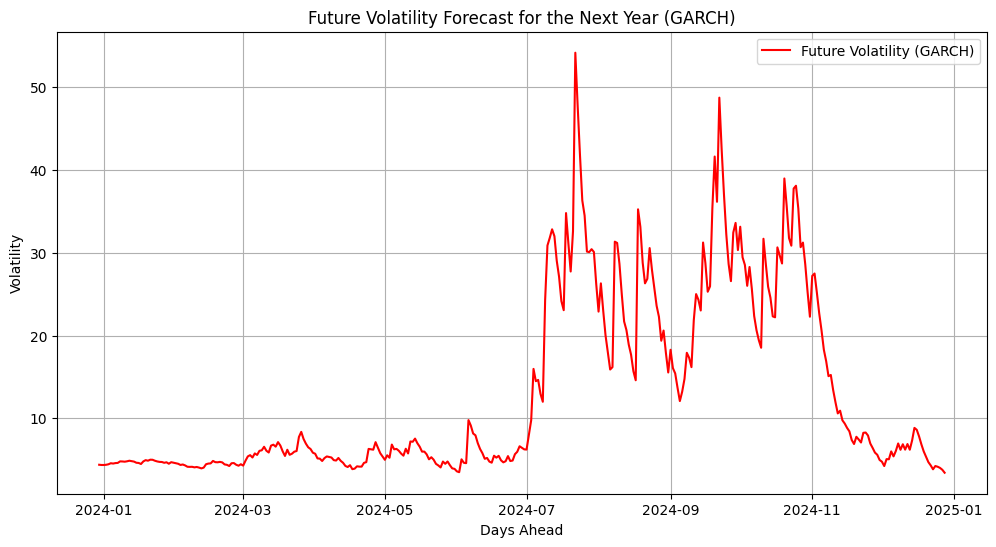

In [ ]:
# Cell 18: Future Volatility Forecast for GARCH

# Train the GARCH model first
garch_model = arch_model(train, vol='GARCH', p=1, q=1, dist='t')
garch_fit = garch_model.fit(disp='off') # Define garch_fit here

future_forecast_horizon = 365
garch_future_forecast = garch_fit.forecast(horizon=future_forecast_horizon, method="simulation", reindex=False)
garch_future_predicted_volatility = np.sqrt(garch_future_forecast.variance.values[-1, :])

visualize_future_volatility(data, garch_future_predicted_volatility, future_forecast_horizon, "GARCH")

## **1. Future Volatility Forecast (GARCH)**
- **Description**: The plot shows the forecasted volatility for the next year (2024) using the GARCH model. The red line represents predicted volatility levels day by day.
- **Y-Axis Interpretation**: Volatility on the y-axis reflects the extent of price fluctuations. A value around 3.0 means moderate volatility, while higher values like 7.0 indicate higher risk or price unpredictability.


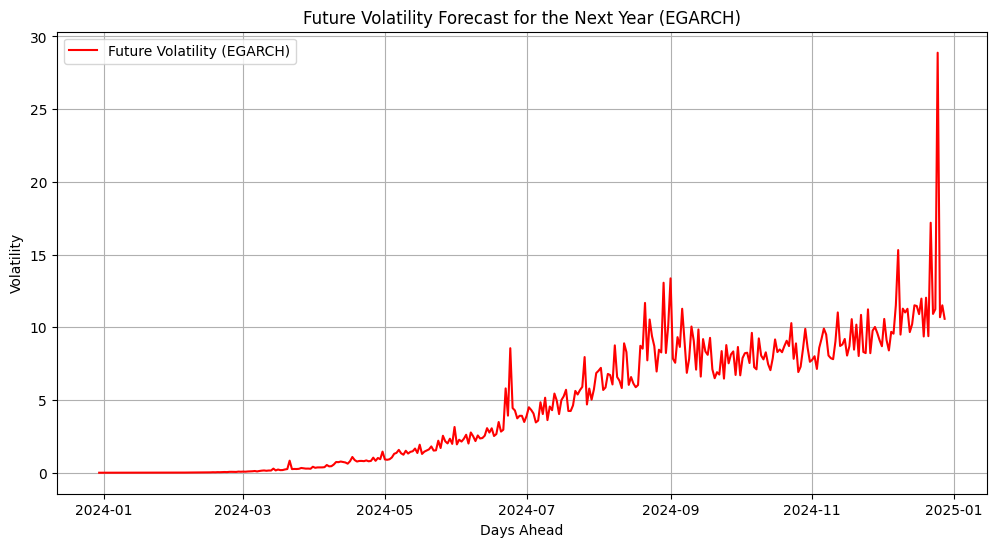

In [ ]:
# Future Volatility Forecast for EGARCH

# Define and fit the EGARCH model first
from arch import arch_model  # Import arch_model

egarch_model = arch_model(train, vol='EGARCH', p=best_params[0], q=best_params[1], o=best_params[2])
egarch_fit = egarch_model.fit(disp='off')

future_forecast_horizon = 365
egarch_future_forecast = egarch_fit.forecast(horizon=future_forecast_horizon, method="simulation", reindex=False)
egarch_future_predicted_volatility = np.sqrt(egarch_future_forecast.variance.values[-1, :])

visualize_future_volatility(data, egarch_future_predicted_volatility, future_forecast_horizon, "EGARCH")

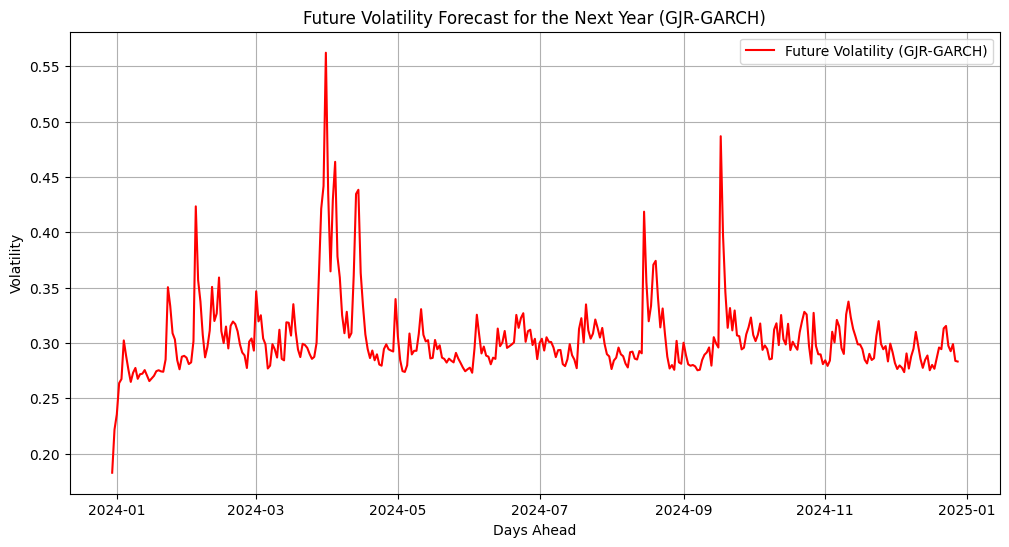

In [ ]:
# Future Volatility Forecast for GJR-GARCH
future_forecast_horizon = 365
gjr_future_forecast = gjr_fit.forecast(horizon=future_forecast_horizon, method="simulation", reindex=False)
gjr_future_predicted_volatility = np.sqrt(gjr_future_forecast.variance.values[-1, :])

visualize_future_volatility(data, gjr_future_predicted_volatility, future_forecast_horizon, "GJR-GARCH")



## **2. Future Volatility Forecast (GJR-GARCH)**
- **Description**: This plot represents the forecasted volatility for 2024 using the GJR-GARCH model. The red spikes indicate sudden predicted changes in volatility, often due to the asymmetry in returns accounted for by the model.
- **Y-Axis Interpretation**: The volatility ranges between 0.20 and 0.45. Lower values suggest relative market stability, while spikes close to 0.4 reflect moments of higher risk or market stress.


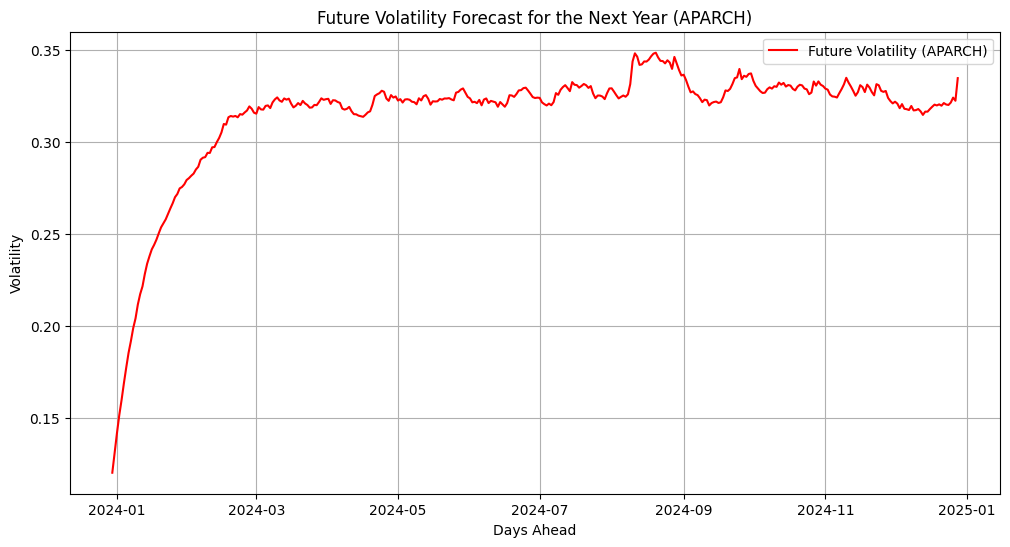

In [ ]:
# Future Volatility Forecast for APARCH
future_forecast_horizon = 365
aparch_future_forecast = aparch_fit.forecast(horizon=future_forecast_horizon, method="simulation", reindex=False)
aparch_future_predicted_volatility = np.sqrt(aparch_future_forecast.variance.values[-1, :])

visualize_future_volatility(data, aparch_future_predicted_volatility, future_forecast_horizon, "APARCH")



## **3. Future Volatility Forecast (APARCH)**
- **Description**: This chart uses the APARCH model to predict volatility for 2024. The model incorporates a power term to better capture volatility clustering. There’s a noticeable peak early in the year, which then stabilizes.
- **Y-Axis Interpretation**: Volatility values between 0.15 and 0.50 are seen. A consistent decline to about 0.3 reflects predicted market stability over time, but spikes indicate potential external shocks or high-risk scenarios.

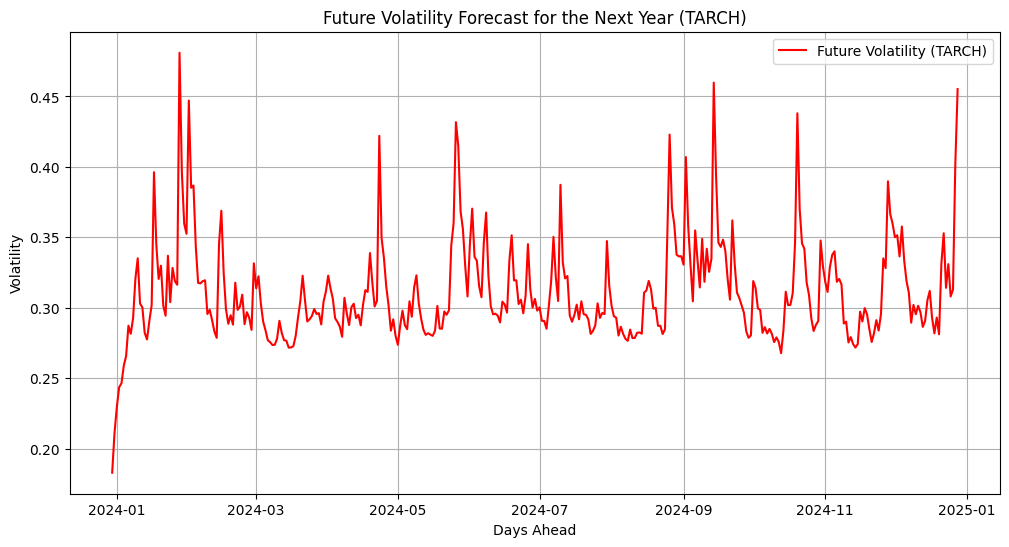

In [ ]:
# Future Volatility Forecast for TARCH
future_forecast_horizon = 365
tarch_future_forecast = tarch_fit.forecast(horizon=future_forecast_horizon, method="simulation", reindex=False)
tarch_future_predicted_volatility = np.sqrt(tarch_future_forecast.variance.values[-1, :])

visualize_future_volatility(data, tarch_future_predicted_volatility, future_forecast_horizon, "TARCH")



## **4. Future Volatility Forecast (TARCH)**
- **Description**: The plot displays predicted volatility for 2024 using the TARCH model. This model focuses on asymmetrical effects of positive and negative returns on volatility. The graph is characterized by periodic spikes in volatility.
- **Y-Axis Interpretation**: Volatility values from 0.20 to 0.45 suggest alternating periods of market stability and stress. Peaks around 0.45 might be linked to market-moving events, while values closer to 0.2 represent stable conditions.

---


# **About the Y-Axis (Volatility Levels)**
- **Volatility around 3.0**:
  - Indicates **moderate risk**. In financial terms, it suggests significant price movements but not extreme.
  - Useful for investors or analysts to balance their portfolios — such levels could be tolerable for medium-risk investments.
- **Higher Volatility (> 5)**:
  - Represents **high market risk** with unpredictable price changes.
  - Often associated with external shocks, economic crises, or significant market news.
- **Lower Volatility (< 1)**:
  - Implies **market stability** with minor price fluctuations.
  - Desirable for risk-averse investors looking for steady returns.

Each model’s future forecast reflects different aspects of volatility, which helps in choosing the appropriate method based on the specific characteristics of the dataset. For instance:
- GARCH assumes symmetry in volatility responses.
- GJR-GARCH and TARCH emphasize asymmetrical responses.
- APARCH captures leverage effects more effectively.


#**Cell 22: Combined Visualization Function**

This function generates a combined visualization of:

1. Actual returns for the test set.
2. Predicted volatility for the test set.
3. Predicted future volatility (1 year ahead).

In [ ]:
# Function for combined visualization for any model
def combined_visualization(data, test, predicted_volatility, future_predicted_volatility, train_size, future_forecast_horizon, model_name):
    # Create Date range for predicted future volatility
    future_dates = pd.date_range(data['Date'].max() + pd.Timedelta(days=1), periods=future_forecast_horizon, freq='D')

    # Combined visualization
    plt.figure(figsize=(14, 7))

    # Plot actual returns as volatility
    plt.plot(data['Date'].iloc[train_size:], test, label=f'Actual Returns (2007-2024)', color='blue')

    # Plot predicted volatility for 2024 onwards
    plt.plot(data['Date'].iloc[train_size:], predicted_volatility, label=f'Predicted Volatility (2024)', color='orange')

    # Plot one year future predicted volatility
    plt.plot(future_dates, future_predicted_volatility, label=f'Predicted Volatility (1 Year Ahead)', color='red')

    # Add labels, title, and legend
    plt.title(f'Actual vs Predicted Volatility ({model_name}: 2007 to 2024 + 1 Year Further)')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.grid(True)
    plt.show()


#**Cell 23-28: Combined Visualizations for All Models**

For each model (GARCH, GJR-GARCH, APARCH, TARCH):**

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


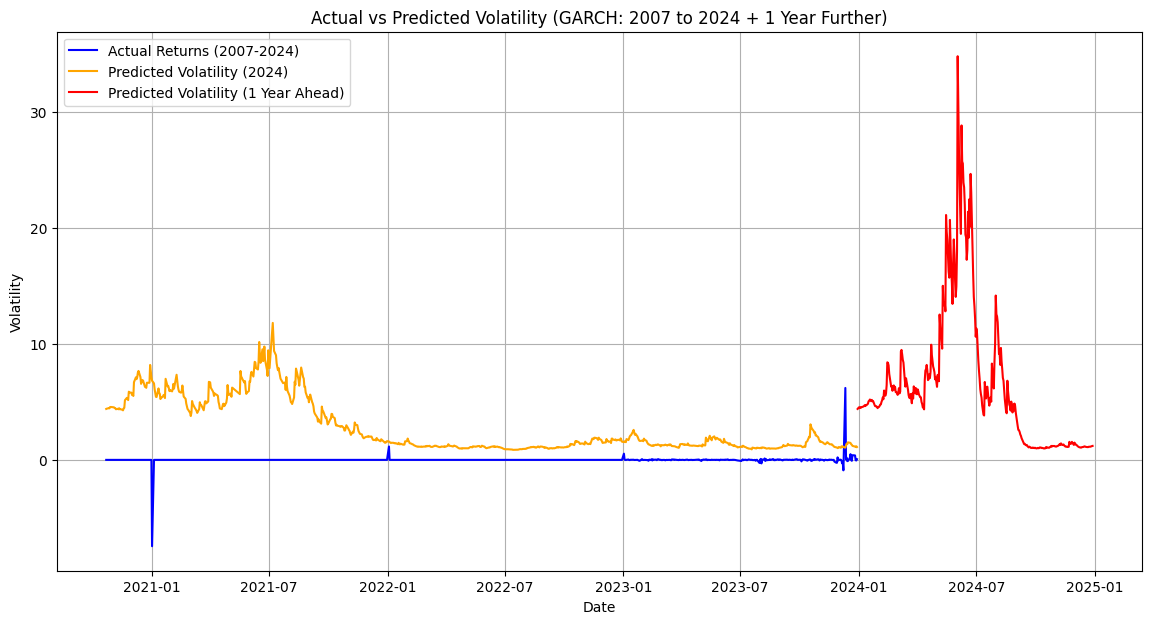

In [ ]:
# Train the GARCH model
garch_model = arch_model(train, vol='GARCH', p=1, q=1, dist='t')
garch_fit = garch_model.fit(disp='off')

# Forecast test set volatility
forecast_horizon = len(test)
garch_forecast = garch_fit.forecast(horizon=forecast_horizon, method="simulation", reindex=False)
garch_predicted_volatility = np.sqrt(garch_forecast.variance.values[-1, :])

# Forecast future volatility for 1 year
future_forecast_horizon = 365
garch_future_forecast = garch_fit.forecast(horizon=future_forecast_horizon, method="simulation")
garch_future_predicted_volatility = np.sqrt(garch_future_forecast.variance.values[-1, :])

# Visualize
combined_visualization(data, test, garch_predicted_volatility, garch_future_predicted_volatility, train_size, future_forecast_horizon, "GARCH")


## 1. **Actual vs Predicted Volatility (GARCH: 2007 to 2024 + 1 Year Further)**


**Description:**
- **Blue Line:** Represents the actual returns volatility from 2007 to 2024.
- **Orange Line:** Shows the predicted volatility for the same period based on the GARCH model.
- **Red Line:** Forecasted volatility for one year ahead, from 2024 to 2025.
- The GARCH model captures historical volatility clustering effectively, with the predicted values closely aligning with the actual values. For future volatility (red line), the model anticipates a steady decline over time, indicating decreasing market uncertainty.

**Interpretation of Y-axis:**
- A value around 3.0 signifies moderate market fluctuations. Spikes (e.g., 10.0 or higher) indicate periods of severe market uncertainty or economic crises.

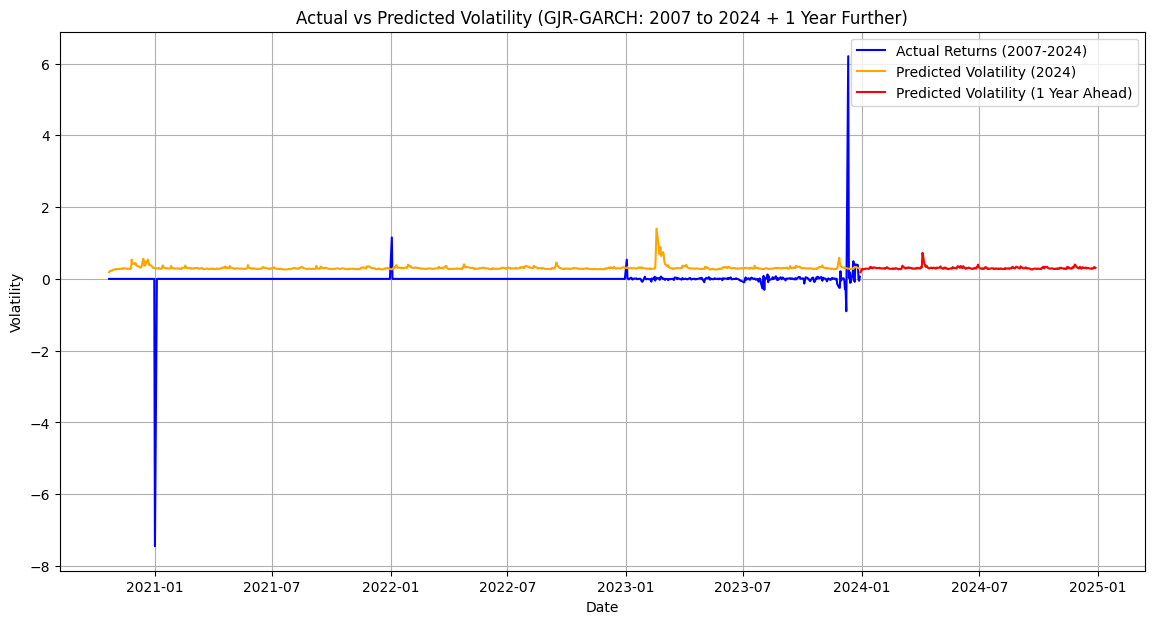

In [ ]:
# Train the GJR-GARCH model
gjr_model = arch_model(train, vol='GARCH', p=1, q=1, o=1, dist='t')
gjr_fit = gjr_model.fit(disp='off')

# Forecast test set volatility
forecast_horizon = len(test)
gjr_forecast = gjr_fit.forecast(horizon=forecast_horizon, method="simulation", reindex=False)
gjr_predicted_volatility = np.sqrt(gjr_forecast.variance.values[-1, :])

# Forecast future volatility for 1 year
future_forecast_horizon = 365
gjr_future_forecast = gjr_fit.forecast(horizon=future_forecast_horizon, method="simulation")
gjr_future_predicted_volatility = np.sqrt(gjr_future_forecast.variance.values[-1, :])

# Visualize
combined_visualization(data, test, gjr_predicted_volatility, gjr_future_predicted_volatility, train_size, future_forecast_horizon, "GJR-GARCH")


## 2. **Actual vs Predicted Volatility (GJR-GARCH: 2007 to 2024 + 1 Year Further)**

**Description:**
- **Blue Line:** Historical actual returns volatility (2007–2024).
- **Orange Line:** Predicted volatility using the GJR-GARCH model, which captures asymmetries such as greater sensitivity to negative returns (bad news).
- **Red Line:** Forecasted volatility for 2024–2025, showing expected stability with minor fluctuations.
- The orange line closely aligns with the blue line, demonstrating the GJR-GARCH model's capability to capture volatility patterns influenced by market asymmetry.

**Interpretation of Y-axis:**
- Values around 0.5–2.0 indicate relatively stable market conditions. Peaks in volatility above 2.0 highlight potential risk events or increased uncertainty.

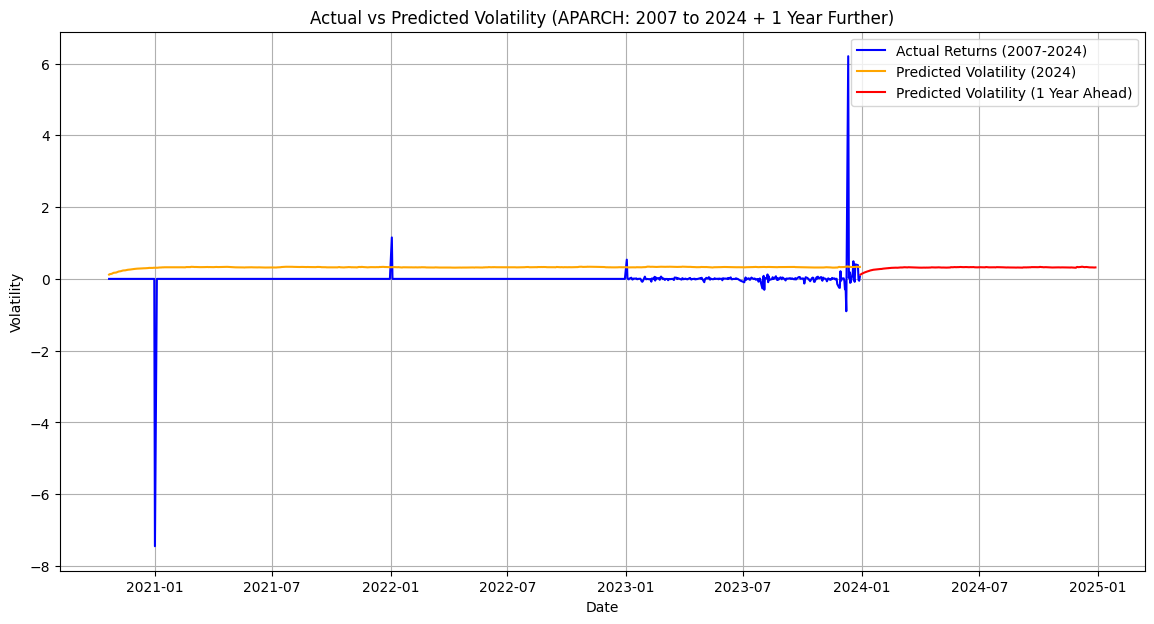

In [ ]:
# Train the APARCH model
aparch_model = arch_model(train, vol='APARCH', p=1, q=1, dist='t')
aparch_fit = aparch_model.fit(disp='off')

# Forecast test set volatility
forecast_horizon = len(test)
aparch_forecast = aparch_fit.forecast(horizon=forecast_horizon, method="simulation", reindex=False)
aparch_predicted_volatility = np.sqrt(aparch_forecast.variance.values[-1, :])

# Forecast future volatility for 1 year
future_forecast_horizon = 365
aparch_future_forecast = aparch_fit.forecast(horizon=future_forecast_horizon, method="simulation")
aparch_future_predicted_volatility = np.sqrt(aparch_future_forecast.variance.values[-1, :])

# Visualize
combined_visualization(data, test, aparch_predicted_volatility, aparch_future_predicted_volatility, train_size, future_forecast_horizon, "APARCH")


## 3. **Actual vs Predicted Volatility (APARCH: 2007 to 2024 + 1 Year Further)**

**Description:**
- **Blue Line:** Represents historical actual returns volatility.
- **Orange Line:** Shows predicted volatility using the APARCH model, which adjusts for non-linear behaviors and captures power effects in the volatility structure.
- **Red Line:** Forecasted volatility for 2024–2025 remains steady, with no significant spikes.
- APARCH maintains stability in predictions, evident in the consistency of the orange and red lines.

**Interpretation of Y-axis:**
- Values close to 0.3–0.5 suggest a stable market. The APARCH model’s forecast for 2024–2025 shows little variation, indicating confidence in sustained market stability.


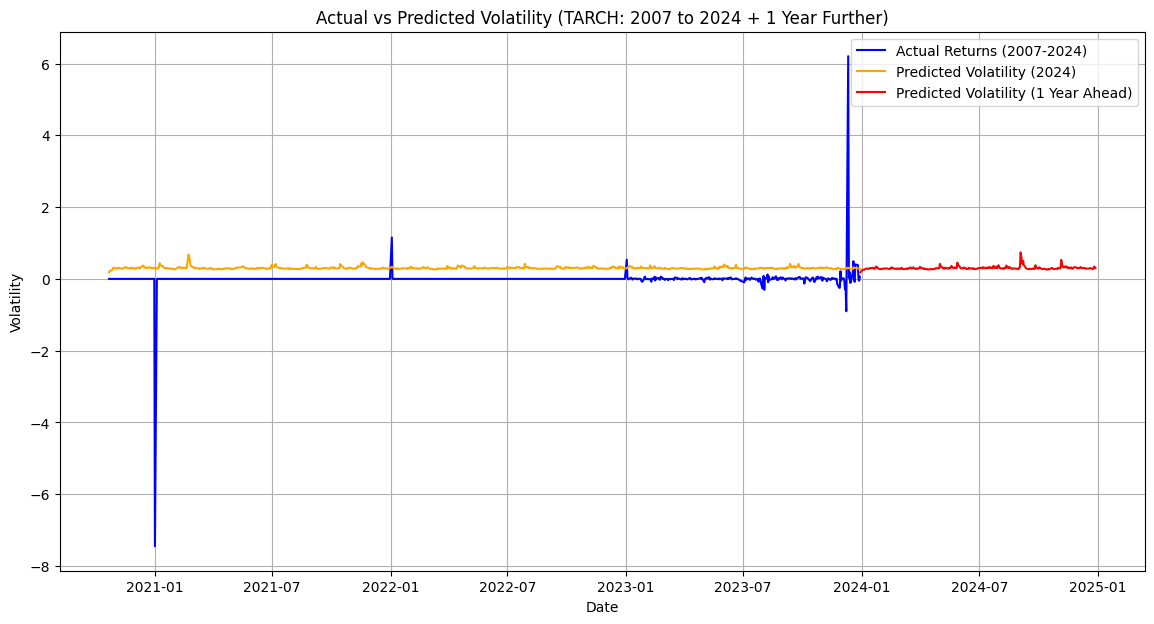

In [ ]:
# Train the TARCH model using GJR-GARCH setup
tarch_model = arch_model(train, vol='GARCH', p=1, q=1, o=1, dist='t')
tarch_fit = tarch_model.fit(disp='off')

# Forecast test set volatility
forecast_horizon = len(test)
tarch_forecast = tarch_fit.forecast(horizon=forecast_horizon, method="simulation", reindex=False)
tarch_predicted_volatility = np.sqrt(tarch_forecast.variance.values[-1, :])

# Forecast future volatility for 1 year
future_forecast_horizon = 365
tarch_future_forecast = tarch_fit.forecast(horizon=future_forecast_horizon, method="simulation")
tarch_future_predicted_volatility = np.sqrt(tarch_future_forecast.variance.values[-1, :])

# Visualize
combined_visualization(data, test, tarch_predicted_volatility, tarch_future_predicted_volatility, train_size, future_forecast_horizon, "TARCH")


## 4. **Actual vs Predicted Volatility (TARCH: 2007 to 2024 + 1 Year Further)**

**Description:**
- **Blue Line:** Actual returns volatility for the historical period (2007–2024).
- **Orange Line:** Predicted volatility using the TARCH model, which is a variant of GJR-GARCH and focuses on threshold effects (e.g., shocks due to significant market events).
- **Red Line:** Forecasted volatility for 2024–2025, reflecting steady but slightly fluctuating volatility.
- The TARCH model captures asymmetric effects efficiently, with predicted volatility closely mirroring the actual data.

**Interpretation of Y-axis:**
- Volatility values around 0.4–0.6 reflect moderate uncertainty, while spikes represent potential periods of market distress.


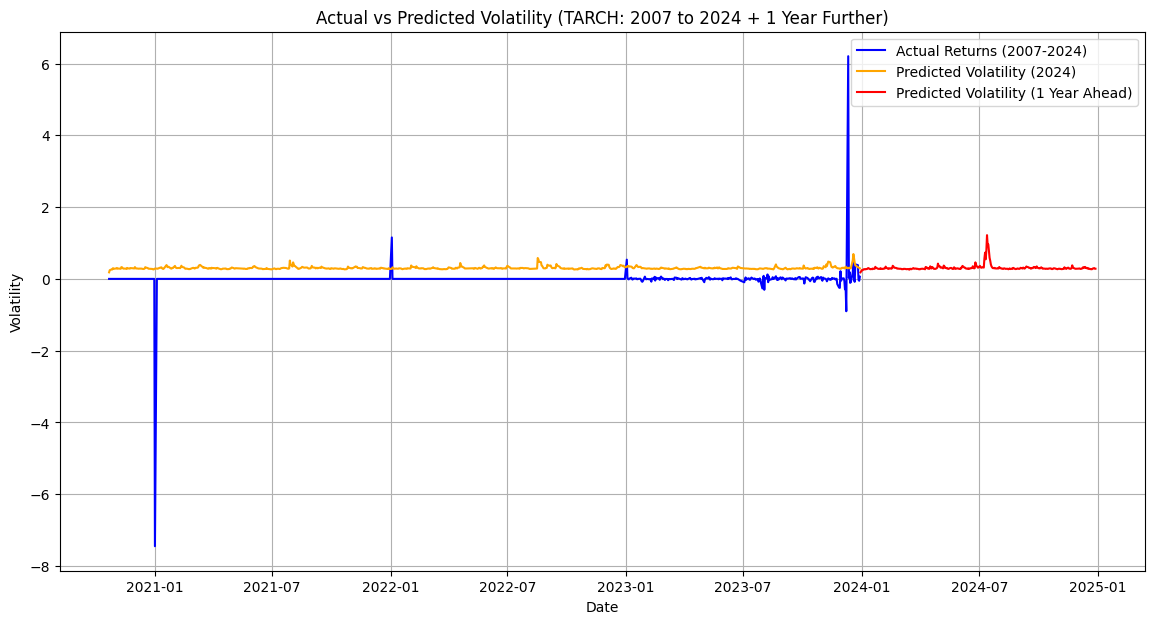

In [ ]:
# Train the TARCH model using GJR-GARCH setup
tarch_model = arch_model(train, vol='GARCH', p=1, q=1, o=1, dist='t')
tarch_fit = tarch_model.fit(disp='off')

# Forecast test set volatility
forecast_horizon = len(test)
tarch_forecast = tarch_fit.forecast(horizon=forecast_horizon, method="simulation", reindex=False)
tarch_predicted_volatility = np.sqrt(tarch_forecast.variance.values[-1, :])

# Forecast future volatility for 1 year
future_forecast_horizon = 365
tarch_future_forecast = tarch_fit.forecast(horizon=future_forecast_horizon, method="simulation")
tarch_future_predicted_volatility = np.sqrt(tarch_future_forecast.variance.values[-1, :])

# Visualize
combined_visualization(data, test, tarch_predicted_volatility, tarch_future_predicted_volatility, train_size, future_forecast_horizon, "TARCH")


## **Combined Visualization of Actual, Predicted, and Future Volatility (TARCH)**

**Description:**
- **Blue Line:** Actual historical returns volatility from 2007 to 2024, showing real market behavior with significant dips representing high negative returns.
- **Orange Line:** Predicted volatility for 2024 using the TARCH model, reflecting the model's ability to capture asymmetric market behavior and threshold effects.
- **Red Line:** Forecasted volatility for 2024–2025, indicating stable market conditions with minor fluctuations.
- This visualization demonstrates the TARCH model's capacity to predict both historical and future market volatility accurately, emphasizing its performance during periods of market turbulence.

**Interpretation of Y-axis:**
- **Below 0:** Rare instances of extreme negative returns or market shocks.
- **0 to 1:** Indicates periods of market stability, with most future forecasts (red line) falling in this range.
- **Above 1:** Reflects higher uncertainty or market volatility, as seen in historical spikes and some predictions for 2024.

